In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from job_pipeline import collect_posts, clean_posts

In [2]:
raw_df = collect_posts(remoteok_limit=150, remotive_limit=150)
processed_df = clean_posts(raw_df)

print("Raw:", len(raw_df))
print("Processed:", len(processed_df))
print(processed_df["source"].value_counts())

Raw: 111
Processed: 111
source
RemoteOK    100
Remotive     11
Name: count, dtype: int64


In [3]:
raw_df.to_csv("jobs_raw.csv", index=False)
processed_df.to_csv("jobs_processed.csv", index=False)
print("Saved jobs_raw.csv and jobs_processed.csv")


Saved jobs_raw.csv and jobs_processed.csv


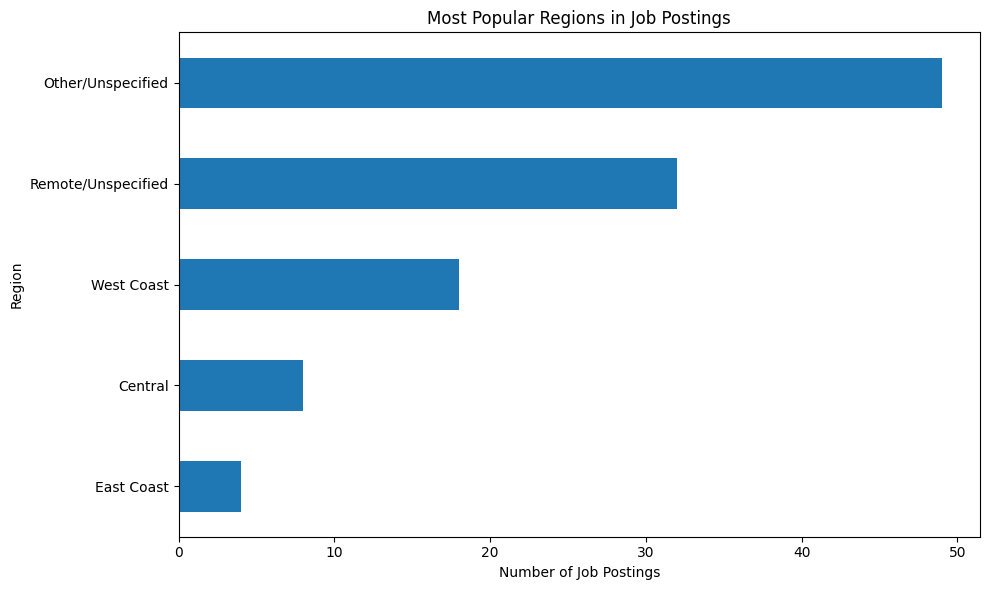

In [4]:
region_counts = processed_df["region"].fillna("Unknown").value_counts()

plt.figure(figsize=(10, 6))
region_counts.sort_values().plot(kind="barh")
plt.title("Most Popular Regions in Job Postings")
plt.xlabel("Number of Job Postings")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


                                                Analysis 1 (top skills + top roles) 

In [ ]:
def explode_skills(df: pd.DataFrame) -> pd.DataFrame:
    s = df[["source", "role_category", "region", "skills", "salary_mid_usd_year"]].copy()
    s = s.explode("skills").dropna(subset=["skills"]).reset_index(drop=True)
    s["skills"] = s["skills"].astype(str)
    return s

skills_long = explode_skills(processed_df)

top_skills = skills_long["skills"].value_counts().head(20)
top_roles = processed_df["role_category"].value_counts().head(15)

top_skills, top_roles

(skills
 react               16
 aws                 15
 kubernetes          13
 typescript          11
 java                 9
 python               8
 sql                  8
 javascript           7
 docker               7
 postgresql           6
 gcp                  5
 node                 5
 azure                4
 git                  4
 machine learning     4
 mysql                3
 computer vision      2
 mongodb              1
 r                    1
 nlp                  1
 Name: count, dtype: int64,
 role_category
 Other                90
 Software Engineer    16
 DevOps                3
 Data Engineer         2
 Name: count, dtype: int64)

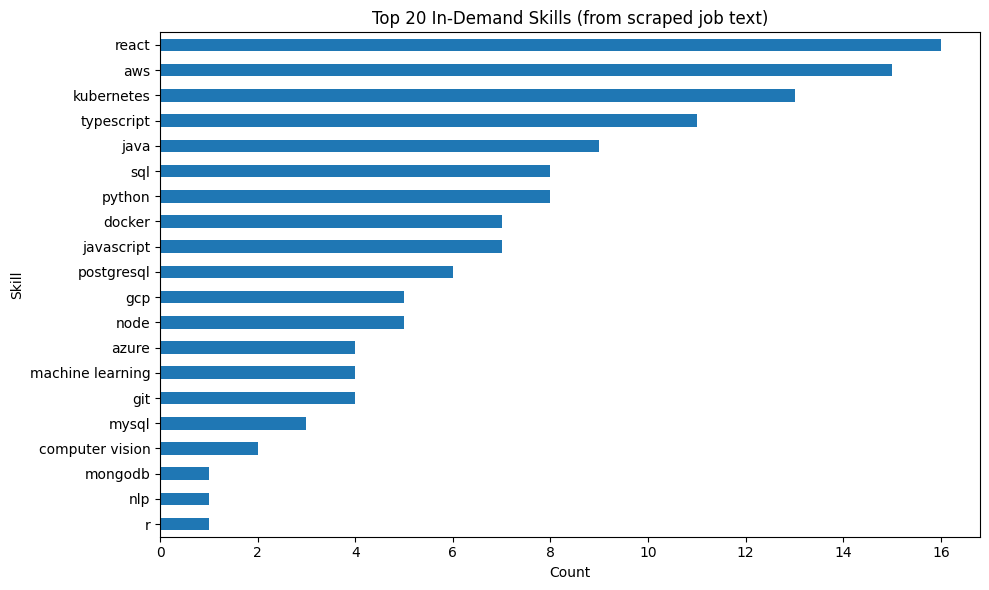

In [7]:
plt.figure(figsize=(10, 6))
top_skills.sort_values().plot(kind="barh")
plt.title("Top 20 In-Demand Skills (from scraped job text)")
plt.xlabel("Count")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

                                          Skill correlations via co-occurrence matrix

In [ ]:
TOP_N = 18
top_skill_list = top_skills.head(TOP_N).index.tolist()

skill_bin = pd.DataFrame(0, index=processed_df.index, columns=top_skill_list, dtype=int)
for i, skills in enumerate(processed_df["skills"].tolist()):
    skill_set = set(skills or [])
    for sk in top_skill_list:
        if sk in skill_set:
            skill_bin.iloc[i, skill_bin.columns.get_loc(sk)] = 1

skill_corr = skill_bin.corr().fillna(0.0)

skill_corr.iloc[:5, :5]

,react,aws,kubernetes,typescript,java
react,1.000000,0.137888,0.329124,0.550633,0.441903
aws,0.137888,1.000000,0.265789,0.309875,0.172212
kubernetes,0.329124,0.265789,1.000000,0.254264,-0.005548
typescript,0.550633,0.309875,0.254264,1.000000,0.122402
java,0.441903,0.172212,-0.005548,0.122402,1.000000


                                                           Heatmap

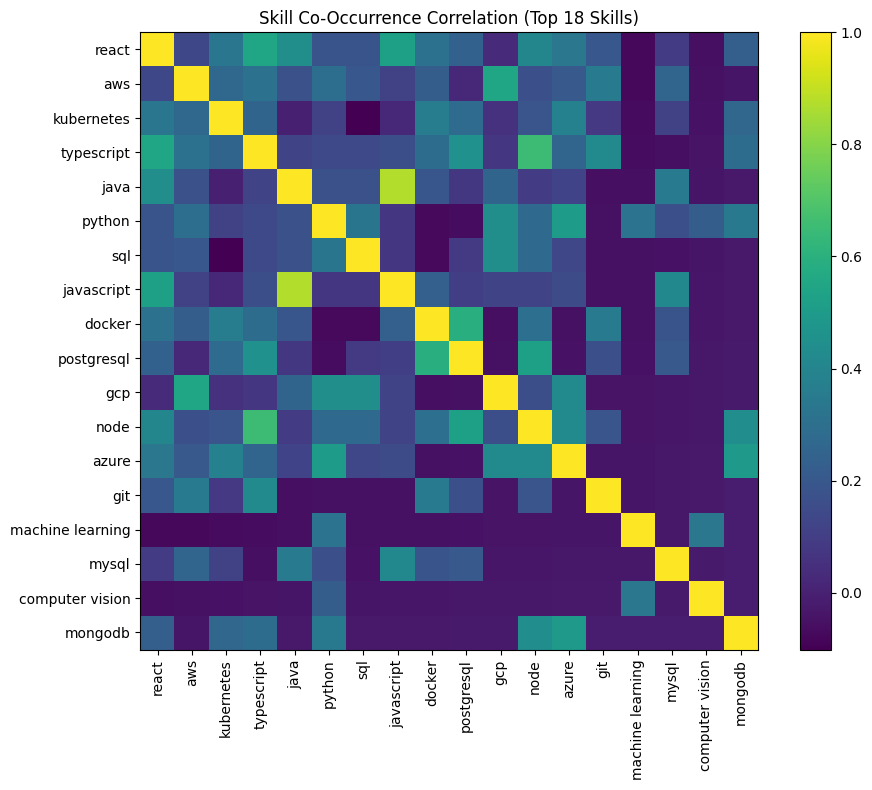

In [9]:
# =========================================
# Cell 17: Visualization 5 (Heatmap-like correlation using matplotlib imshow)
# =========================================
plt.figure(figsize=(10, 8))
plt.imshow(skill_corr.values)
plt.title(f"Skill Co-Occurrence Correlation (Top {TOP_N} Skills)")
plt.xticks(range(len(top_skill_list)), top_skill_list, rotation=90)
plt.yticks(range(len(top_skill_list)), top_skill_list)
plt.colorbar()
plt.tight_layout()
plt.show()

                                            Final clean dataset preview

In [12]:
cols = [
    "source", "title", "company", "location", "region",
    "role_category", "num_skills", "skills",
    "salary_raw", "salary_mid_usd_year", "url"
]
processed_df[cols].head(20)


,source,title,company,location,region,role_category,num_skills,skills,salary_raw,salary_mid_usd_year,url
0,RemoteOK,Finance Manager,ReFED,USA,Other/Unspecified,Other,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-financ...
1,RemoteOK,Senior Systems Engineer Software,2100 NVIDIA USA,"US, CA, Remote",West Coast,Other,4,"[aws, gcp, azure, kubernetes]",,NaN,https://remoteOK.com/remote-jobs/remote-senior...
2,RemoteOK,Software Engineer Infrastructure Supercomputing,xAI,Palo Alto,East Coast,Software Engineer,1,[kubernetes],,NaN,https://remoteOK.com/remote-jobs/remote-softwa...
3,RemoteOK,Staff DevOps Engineer,Heartflow,San Francisco,Central,DevOps,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-staff-...
4,RemoteOK,Digital Marketing Manager Online Opportunity,mindmoneyreset,,Other/Unspecified,Other,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-digita...
5,RemoteOK,Partnership Head,HR Force International,,Other/Unspecified,Other,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-partne...
6,RemoteOK,Danish Speaking Jobs Greece Work Greece Fully ...,Mercier Consultancy MD,,Other/Unspecified,Other,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-danish...
7,RemoteOK,French Speaking Jobs Greece Work Greece Fully ...,Mercier Consultancy MD,,Other/Unspecified,Other,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-french...
8,RemoteOK,Danish Speaking Jobs Greece Work Greece Fully ...,Mercier Consultancy MD,,Other/Unspecified,Other,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-danish...
9,RemoteOK,Leadership Development Associate,Lifestyle Seed Consulting,,Other/Unspecified,Other,0,[],,NaN,https://remoteOK.com/remote-jobs/remote-leader...
